# Metadata extraction for the datasets

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pathlib import Path
import matplotlib.pyplot as plt
from config import data_processed_folder
data_processed_folder = Path(data_processed_folder)
from timeeval import Datasets, DatasetRecord
from timeeval.datasets import DatasetAnalyzer
import tqdm

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [4]:
dm = Datasets(data_processed_folder)
dm.df()

train_path  \
collection_name dataset_name                
CalIt2          CalIt2-traffic        NaN   
Daphnet         S01R01E0              NaN   
                S01R01E1              NaN   
                S01R02E0              NaN   
                S02R01E0              NaN   
...                                   ...   
WebscopeS5      A4Benchmark-95        NaN   
                A4Benchmark-96        NaN   
                A4Benchmark-97        NaN   
                A4Benchmark-98        NaN   
                A4Benchmark-99        NaN   

                                                                    test_path  \
collection_name dataset_name                                                    
CalIt2          CalIt2-traffic    multivariate/CalIt2/CalIt2-traffic.test.csv   
Daphnet         S01R01E0               multivariate/Daphnet/S01R01E0.test.csv   
                S01R01E1               multivariate/Daphnet/S01R01E1.test.csv   
                S01R02E0               multivariate/Daphnet/S01R02E0.test.csv   
                S02R01E0               multivariate/Daphnet/S02R01E0.test.csv   
...                                                                       ...   
WebscopeS5      A4Benchmark-95  univariate/WebscopeS5/A4Benchmark-95.test.csv   
                A4Benchmark-96  univariate/WebscopeS5/A4Benchmark-96.test.csv   
                A4Benchmark-97  univariate/WebscopeS5/A4Benchmark-97.test.csv   
                A4Benchmark-98  univariate/WebscopeS5/A4Benchmark-98.test.csv   
                A4Benchmark-99  univariate/WebscopeS5/A4Benchmark-99.test.csv   

                               dataset_type  datetime_index  split_at  \
collection_name dataset_name                                            
CalIt2          CalIt2-traffic         real            True       NaN   
Daphnet         S01R01E0               real            True       NaN   
                S01R01E1               real            True       NaN   
                S01R02E0               real            True       NaN   
                S02R01E0               real            True       NaN   
...                                     ...             ...       ...   
WebscopeS5      A4Benchmark-95    synthetic            True       NaN   
                A4Benchmark-96    synthetic            True       NaN   
                A4Benchmark-97    synthetic            True       NaN   
                A4Benchmark-98    synthetic            True       NaN   
                A4Benchmark-99    synthetic            True       NaN   

                                  train_type  train_is_normal    input_type  \
collection_name dataset_name                                                  
CalIt2          CalIt2-traffic  unsupervised            False  multivariate   
Daphnet         S01R01E0        unsupervised            False  multivariate   
                S01R01E1        unsupervised            False  multivariate   
                S01R02E0        unsupervised            False  multivariate   
                S02R01E0        unsupervised            False  multivariate   
...                                      ...              ...           ...   
WebscopeS5      A4Benchmark-95  unsupervised            False    univariate   
                A4Benchmark-96  unsupervised            False    univariate   
                A4Benchmark-97  unsupervised            False    univariate   
                A4Benchmark-98  unsupervised            False    univariate   
                A4Benchmark-99  unsupervised            False    univariate   

                                length  
collection_name dataset_name            
CalIt2          CalIt2-traffic    5040  
Daphnet         S01R01E0         19200  
                S01R01E1         73600  
                S01R02E0         28800  
                S02R01E0         25600  
...                                ...  
WebscopeS5      A4Benchmark-95    1680  
                A4Benchmark-96    1680  
   

In [6]:
dataset = dm.select()[0]
df = dm.get_dataset_df(dataset)
length = len(df)
dimensions = len(df.columns) - 2
contamination = len(df[df["is_anomaly"] == 1]) / length
means = df.iloc[:, 1:-1].mean(axis=0).values
stddevs = df.iloc[:, 1:-1].std(axis=0).values
domain = "number of people entering and leaving the building using the main entrance" # set manually

length, dimensions, contamination, domain, means, stddevs

(5040,
 2,
 0.040873015873015874,
 'number of people entering and leaving the building using the main entrance',
 array([3.88829365, 3.7375    ]),
 array([6.83456465, 6.01037194]))

In [7]:
labels = df["is_anomaly"]
label_groups = labels.groupby((labels.shift() != labels).cumsum())
anomalies = [len(v) for k, v in label_groups if np.all(v)]
num_anomalies = len(anomalies)
min_anomaly_length = np.min(anomalies)
median_anomaly_length = int(np.median(anomalies))
max_anomaly_length = np.max(anomalies)

num_anomalies, min_anomaly_length, median_anomaly_length, max_anomaly_length

(29, 2, 7, 19)

## Analyze stationarity

This analyses uses `statsmodels`' Augmented Dickey Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to find out if an univarate time series is stationary or not (and even if it is trend stationary or difference stationary; in this case it is stationary after trend removal or differencing respectively).

In [8]:
df = df.set_index("timestamp")
df

,in_count,out_count,is_anomaly
timestamp,,,
2005-07-24 00:00:00,0,0,0
2005-07-24 00:30:00,0,1,0
2005-07-24 01:00:00,0,0,0
2005-07-24 01:30:00,0,0,0
2005-07-24 02:00:00,0,0,0
...,...,...,...
2005-11-05 21:30:00,0,0,0
2005-11-05 22:00:00,0,3,0
2005-11-05 22:30:00,0,0,0


In [9]:
# source https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
from statsmodels.tsa.stattools import adfuller, kpss
def adf_stationarity_test(timeseries: pd.DataFrame, sigma: float = 0.05) -> bool:
    print("Results of Augmented Dickey Fuller (ADF) test:")
    adftest = adfuller(timeseries, autolag="AIC")
    adf_output = pd.Series(adftest[0:3], index=['Test Statistic','p-value','Lags Used'])
    print(adf_output)
    return adf_output["p-value"] < sigma

def kpss_trend_stationarity_test(timeseries: pd.DataFrame, sigma: float = 0.05) -> bool:
    print("Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    print(kpss_output)
    return kpss_output["p-value"] < sigma

def get_stationarity(timeseries: pd.Series) -> str:
    stationary = adf_stationarity_test(timeseries)
    trend_stationary = kpss_trend_stationarity_test(timeseries)

    if not stationary and not trend_stationary:
        stationarity = "not stationary"
    elif stationary and trend_stationary:
        stationarity = "stationary"
    elif not stationary and trend_stationary:
        stationarity = "trend stationary" # detrending to make stationary
    else: # if stationary and not trend_stationary:
        stationarity = "difference stationary" # differencing to make stationary
    
    print("-------------------------------------------")
    print(f"Stationarity of series '{timeseries.name}': {stationarity}\n")
    return stationarity

column = "in_count"
in_stationarity = get_stationarity(df[column])

column = "out_count"
out_stationarity = get_stationarity(df[column])

Results of Augmented Dickey Fuller (ADF) test:
Test Statistic   -1.263684e+01
p-value           1.463704e-23
Lags Used         3.200000e+01
dtype: float64
Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test:
Test Statistic     0.320464
p-value            0.100000
Lags Used         39.000000
dtype: float64
-------------------------------------------
Stationarity of series 'in_count': difference stationary

Results of Augmented Dickey Fuller (ADF) test:


/home/sebastian.schmidl/.conda/envs/timeeval38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic   -1.158374e+01
p-value           2.901006e-21
Lags Used         3.200000e+01
dtype: float64
Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test:
Test Statistic     0.544419
p-value            0.031662
Lags Used         39.000000
dtype: float64
-------------------------------------------
Stationarity of series 'out_count': stationary



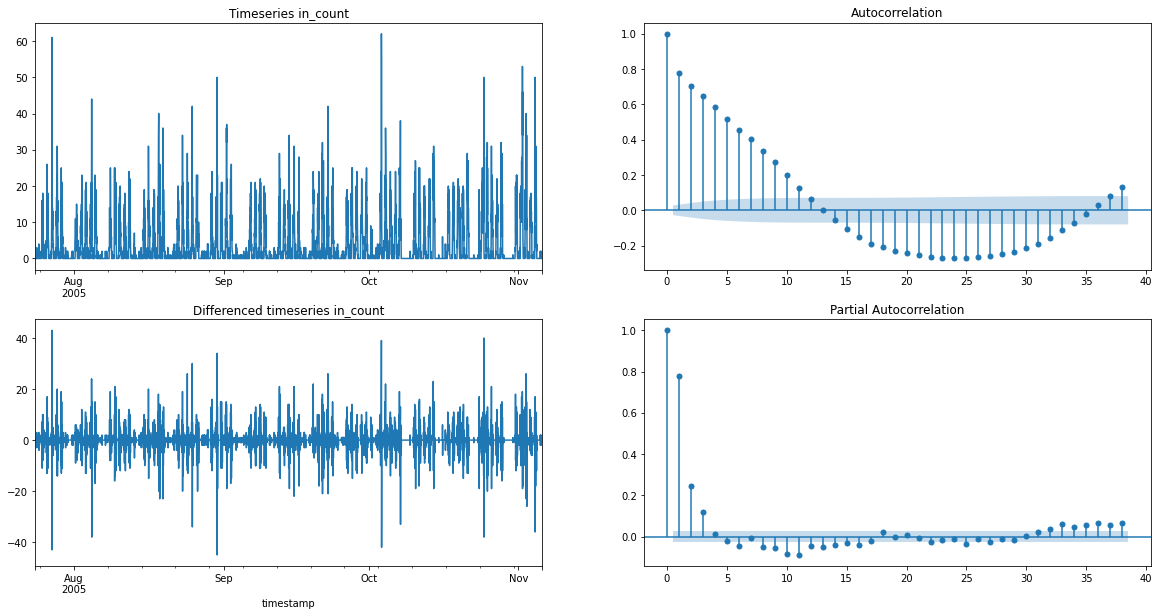

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_series_info(df: pd.DataFrame, series_name: str):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    df[series_name].plot(ax=ax1)
    ax1.set_title(f"Timeseries {series_name}")
    ax1.set_xlabel("")
    df[series_name].diff().plot(ax=ax3)
    ax3.set_title(f"Differenced timeseries {series_name}")

    plot_acf(df[series_name], ax=ax2)
    plot_pacf(df[series_name], ax=ax4)

plot_series_info(df, "in_count")
plt.show()

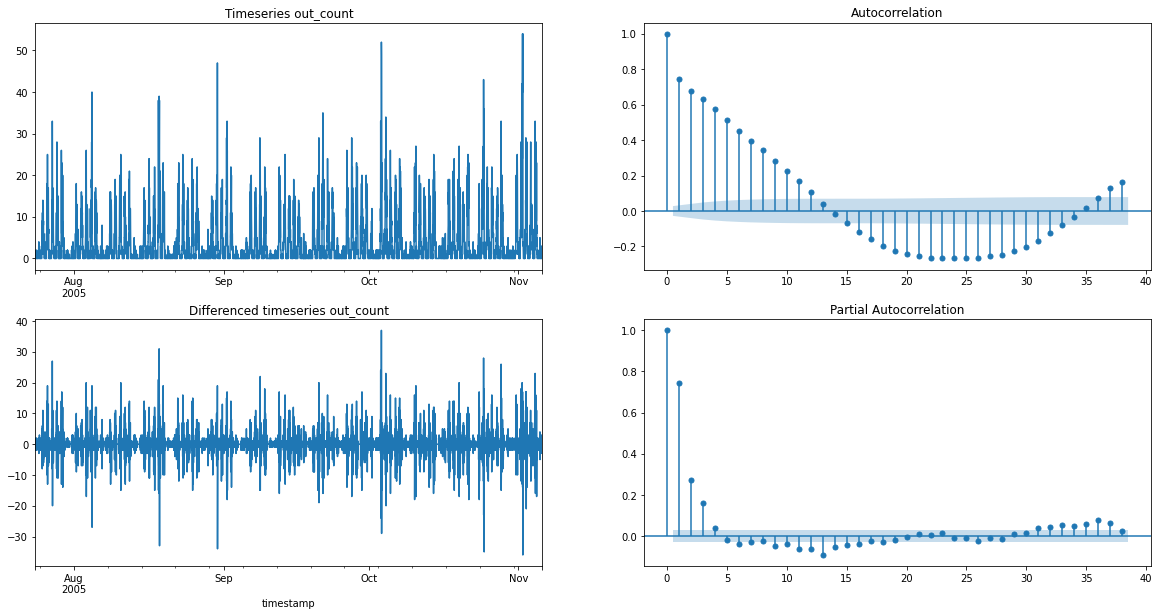

In [11]:
plot_series_info(df, "out_count")
plt.show()

In [12]:
in_stationarity, out_stationarity

('difference stationary', 'stationary')

## Trend and Seasonality Analysis

We fit three different regression models to the data and inspect their coefficient to judge if their are trends in the time series. If the coefficients are larger than a threshold, the corresponding trends exists.

- linear trend
- quadratic trend
- kubic trend

Coef r2
[1.4910128] 0.5228290287255758
[0.00083443] 0.49242526497641403
[5.04217065e-07] 0.45842710806639464


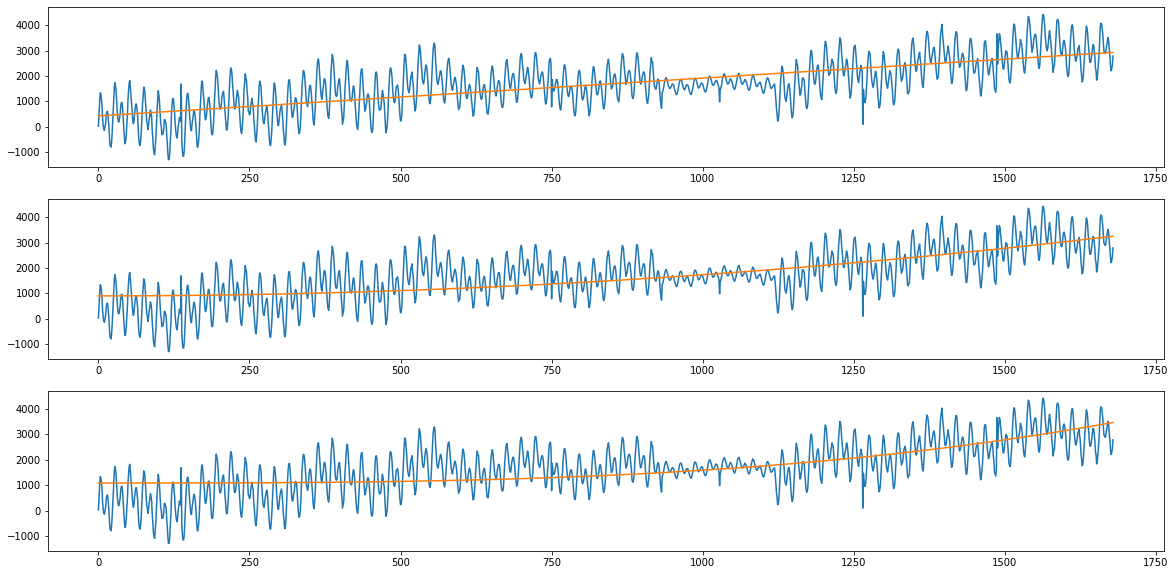

In [13]:
from sklearn.linear_model import LinearRegression
df2 = dm.get_dataset_df(dm.select(dataset_name="A4Benchmark-95")[0])
column = "value"

def get_trend(series, order: int = 1) -> float:
    idx = np.array(range(len(df2)))
    X = np.array(np.power(idx, order)).reshape(-1, 1)
    y = series

    model = LinearRegression()
    model.fit(X, series)
    return model.coef_, model.score(X, y), model.predict(X)

fig, ax = plt.subplots(3)
print("Coef r2")
for order in [1, 2, 3]:
    coef, r2, trend = get_trend(df2[column], order)
    df2[column].plot(ax=ax[order-1])
    ax[order-1].plot(trend)
    print(coef, r2)
plt.show()

In [14]:
np.power(range(len(df2)), 1)

array([   0,    1,    2, ..., 1677, 1678, 1679])

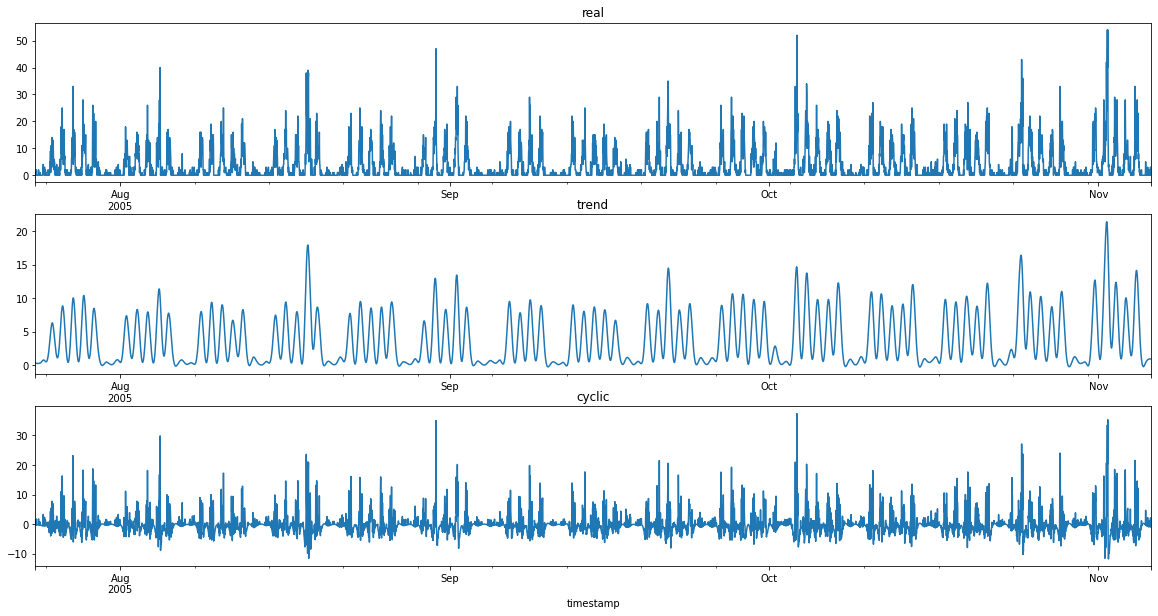

In [15]:
series = df["out_count"]
cycle, trend = sm.tsa.filters.hpfilter(series)
fig, (ax1, ax2, ax3) = plt.subplots(3)
series.plot(ax=ax1, label="real")
ax1.set_title("real")
trend.plot(ax=ax2)
ax2.set_title("trend")
cycle.plot(ax=ax3)
ax3.set_title("cyclic")
plt.show()

## (Re-)calculating all metadata of existing preprocessed datasets

Unsupervised methods:

In [5]:
dmgr = Datasets(data_processed_folder)
dmgr_new = Datasets(data_processed_folder / "new")
unsupervised_datasets = dmgr.select(train_type="unsupervised")
train = False
for dataset in tqdm.tqdm(unsupervised_datasets, desc="Analyzing unsupervised datasets"):
    tqdm.tqdm.write(f"Analyzing dataset {dataset} ({'training' if train else 'testing'})")
    da = DatasetAnalyzer(dataset, is_train=train, dmgr=dmgr)
    meta_file = dmgr.get_dataset_path(dataset, train=train).parent / f"{dataset[1]}.{Datasets.METADATA_FILENAME_PREFIX}"
    da.save_to_json(meta_file, overwrite=True)
    
    base_data = dmgr.df().loc[dataset]
    meta_data = da.metadata
    dmgr_new.add_dataset(DatasetRecord(
        collection_name=dataset[0],
        dataset_name=dataset[1],
        train_path=base_data.train_path,
        test_path=base_data.test_path,
        dataset_type=base_data.dataset_type,
        datetime_index=base_data.datetime_index,
        split_at=base_data.split_at,
        train_type=base_data.train_type,
        train_is_normal=base_data.train_is_normal,
        input_type=base_data.input_type,
        length=meta_data.length,
        dimensions=meta_data.dimensions,
        contamination=meta_data.contamination,
        num_anomalies=meta_data.num_anomalies,
        min_anomaly_length=meta_data.anomaly_length.min,
        median_anomaly_length=meta_data.anomaly_length.median,
        max_anomaly_length=meta_data.anomaly_length.max,
        mean=meta_data.mean,
        stddev=meta_data.stddev,
        trend=meta_data.trend,
        stationarity=meta_data.get_stationarity_name(),
    ))
dmgr_new.save()

Analyzing unsupervised datasets:   0%|          | 0/653 [00:00<?, ?it/s]

Analyzing dataset ('CalIt2', 'CalIt2-traffic') (testing)


[('CalIt2', 'CalIt2-traffic') (test)] /home/projects/akita/data/benchmark-data/data-processed/multivariate/CalIt2/CalIt2-traffic.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.
Analyzing unsupervised datasets:   0%|          | 1/653 [00:00<04:59,  2.17it/s]

Analyzing dataset ('Daphnet', 'S01R01E0') (testing)


[('Daphnet', 'S01R01E0') (test)] /home/projects/akita/data/benchmark-data/data-processed/multivariate/Daphnet/S01R01E0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.
Analyzing unsupervised datasets:   0%|          | 2/653 [00:11<39:15,  3.62s/it]

Analyzing dataset ('Daphnet', 'S01R01E1') (testing)


[('Daphnet', 'S01R01E1') (test)] /home/projects/akita/data/benchmark-data/data-processed/multivariate/Daphnet/S01R01E1.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.
Analyzing unsupervised datasets:   0%|          | 3/653 [01:39<5:13:02, 28.90s/it]

Analyzing dataset ('Daphnet', 'S01R02E0') (testing)


[('Daphnet', 'S01R02E0') (test)] /home/projects/akita/data/benchmark-data/data-processed/multivariate/Daphnet/S01R02E0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.
Analyzing unsupervised datasets:   1%|          | 4/653 [01:59<4:43:35, 26.22s/it]

Analyzing dataset ('Daphnet', 'S02R01E0') (testing)


[('Daphnet', 'S02R01E0') (test)] /home/projects/akita/data/benchmark-data/data-processed/multivariate/Daphnet/S02R01E0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.
Analyzing unsupervised datasets:   1%|          | 5/653 [02:15<4:11:14, 23.26s/it]

Analyzing dataset ('Daphnet', 'S02R02E0') (testing)


[('Daphnet', 'S02R02E0') (test)] /home/projects/akita/data/benchmark-data/data-processed/multivariate/Daphnet/S02R02E0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.
Analyzing unsupervised datasets:   1%|          | 6/653 [03:25<6:42:18, 37.31s/it]

Analyzing dataset ('Daphnet', 'S03R01E0') (testing)


[('Daphnet', 'S03R01E0') (test)] /home/projects/akita/data/benchmark-data/data-processed/multivariate/Daphnet/S03R01E0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.
Analyzing unsupervised datasets:   1%|          | 7/653 [04:19<7:36:17, 42.38s/it]

Analyzing dataset ('Daphnet', 'S03R01E1') (testing)


[('Daphnet', 'S03R01E1') (test)] /home/projects/akita/data/benchmark-data/data-processed/multivariate/Daphnet/S03R01E1.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.
Analyzing unsupervised datasets:   1%|          | 8/653 [04:47<6:46:45, 37.84s/it]

Analyzing dataset ('Daphnet', 'S03R02E0') (testing)


[('Daphnet', 'S03R02E0') (test)] /home/projects/akita/data/benchmark-data/data-processed/multivariate/Daphnet/S03R02E0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.
Analyzing unsupervised datasets:   1%|▏         | 9/653 [04:56<5:13:20, 29.19s/it]

Analyzing dataset ('Daphnet', 'S03R03E0') (testing)


[('Daphnet', 'S03R03E0') (test)] KPSS trend stationarity test encountered an error: cannot convert float NaN to integer
[('Daphnet', 'S03R03E0') (test)] KPSS trend stationarity test encountered an error: cannot convert float NaN to integer
[('Daphnet', 'S03R03E0') (test)] KPSS trend stationarity test encountered an error: cannot convert float NaN to integer
Analyzing unsupervised datasets:   2%|▏         | 10/653 [05:07<4:15:44, 23.86s/it]

Analyzing dataset ('Daphnet', 'S04R01E0') (testing)


Analyzing unsupervised datasets:   2%|▏         | 10/653 [07:06<7:36:38, 42.61s/it]


KeyboardInterrupt: 